<a href="https://colab.research.google.com/github/harry-erskine/PRBX-Travel-Mode-Identification/blob/main/Source%20Code/Convoluted%20Neural%20Networks/CNN_with_group_size_of_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ML - Convolutional Neural Network**

### **Data Preferences**

In [ ]:
### VARIABLES ###

groupSize = 64                  # How many trajectories are represented in each group
motion_points = groupSize - 3    # Do not change this variable

# variables below all 'True' or 'False' (where all 'False' represents the most filtered version of the data)

include_impossible_groups = False      # include groups with trajectories that I have deemed to be invalid
include_stationary_groups = False      # include groups where there is less than 3 meters of total movement
include_airplane_and_boat = False      # include groups where the mode of transportation was 'airplane' or 'boat'
include_all_time_ranges = True        # include groups where the time between each trajectory is more than 1 second

### **Notebook Setup**

In [ ]:
### INSTALLS ###

# !pip install --upgrade gspread
# !pip install pandas
# !pip install scikit-learn
# !pip install tensorflow

In [ ]:
### IMPORTS ###

import os
from google.colab import drive
import pandas as pd
import numpy as np
import time
#
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# import graphviz
# from sklearn import metrics, tree
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
#
# import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets
# import torchvision.transforms as transforms
# import torch.nn.functional as F

In [ ]:
### MOUNT GOOGLE DRIVE ###

mainMountPath = '/content/gdrive'
mainDrivePath = '/content/gdrive/MyDrive/Colab Notebooks/PRBX'

drive.mount(mainMountPath, force_remount=True)

Mounted at /content/gdrive


In [ ]:
### FILE PATHS ###

generatedFilesPath = mainDrivePath + '/Data Files/Generated Files'
cleanedMotionDataPath = generatedFilesPath + '/cleanedMotionDataX' + str(groupSize) + '.csv'

In [ ]:
cmdf = pd.read_csv(cleanedMotionDataPath)
cmdf = cmdf.drop('Unnamed: 0', axis=1)

In [ ]:
df = cmdf

if include_impossible_groups == False:
  df = df[df['Impossible'] == False]

if include_stationary_groups == False:
  df = df[df['Stationary'] == False]

if include_airplane_and_boat == False:
  df.drop(df[df['Mode'] == 'airplane'].index, inplace=True)
  df.drop(df[df['Mode'] == 'boat'].index, inplace=True)

if include_all_time_ranges == False:
  df = df[df['DT Max'] == 1]

df

,GroupId,UserId,Mode,Old Mode,S0,S1,S2,S3,S4,S5,...,AA RC6,BR RC0,BR RC1,BR RC2,BR RC3,BR RC4,BR RC5,BR RC6,Impossible,Stationary
0,1,10,walk,walk,1.290664,1.224914,1.376708,1.204619,1.224677,0.819108,...,1,25,16,13,4,0,0,3,False,False
1,2,10,walk,walk,0.681000,0.688277,1.038191,0.922671,0.688277,0.884311,...,0,31,15,14,1,0,0,0,False,False
2,3,10,walk,walk,1.248763,1.224931,1.248763,1.038498,1.203524,1.140418,...,2,30,8,17,6,0,0,0,False,False
3,4,10,car,taxi,2.929182,2.251940,2.789066,3.139866,4.168532,4.373653,...,1,24,18,14,4,0,0,1,False,False
4,5,10,car,taxi,5.604982,5.110029,5.593743,4.934521,6.768173,6.461606,...,1,48,8,4,1,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,54704,179,walk,walk,0.580804,0.350055,0.256300,0.446187,0.569735,0.280044,...,0,21,18,6,1,3,3,9,False,False
54704,54705,179,train,subway,17.207388,18.453417,18.690503,19.779781,22.606373,22.056521,...,0,54,1,3,0,2,1,0,False,False
54705,54706,179,train,subway,1.812836,3.695013,6.378706,9.826695,15.875429,17.510840,...,0,59,1,1,0,0,0,0,False,False
54706,54707,179,train,subway,3.702988,2.356879,1.413526,1.759520,1.100953,0.810423,...,0,41,8,4,1,2,2,3,False,False


In [ ]:
print(df['Mode'].unique())

['walk' 'car' 'bus' 'train' 'bike']


In [ ]:
# Names of raw motion features
raw_speed_features =          [f'S{i}' for i in range(motion_points)]
raw_acceleration_features =   [f'A{i}' for i in range(motion_points)]
raw_jerk_features =           [f'J{i}' for i in range(motion_points)]
raw_alti_velocity_features =  [f'AV{i}' for i in range(motion_points)]
raw_alti_accel_features =     [f'AA{i}' for i in range(motion_points)]
raw_bearing_rate_features =   [f'BR{i}' for i in range(motion_points)]

raw_motion_features = raw_speed_features + raw_acceleration_features + raw_jerk_features + \
                      raw_alti_velocity_features + raw_bearing_rate_features

#### features that aren't used by the CNN

In [ ]:
# # Names of derived motion features
# derived_speed_features =          ['S Min', 'S 25% Q', 'S Mean', 'S Median', 'S 75% Q', 'S Max', 'S Range', 'S IQR']
# derived_acceleration_features =   ['A Min', 'A 25% Q', 'A Mean', 'A Median', 'A 75% Q', 'A Max', 'A Range', 'A IQR']
# derived_jerk_features =           ['J Min', 'J 25% Q', 'J Mean', 'J Median', 'J 75% Q', 'J Max', 'J Range', 'J IQR']
# derived_alti_velocity_features =  ['AV Min', 'AV 25% Q', 'AV Mean', 'AV Median', 'AV 75% Q', 'AV Max', 'AV Range', 'AV IQR']
# derived_alti_accel_features =     ['AA Min', 'AA 25% Q', 'AA Mean', 'AA Median', 'AA 75% Q', 'AA Max', 'AA Range', 'AA IQR']
# derived_bearing_rate_features =   ['BR Min', 'BR 25% Q', 'BR Mean', 'BR Median', 'BR 75% Q', 'BR Max', 'BR Range', 'BR IQR']

# # another way of formatting names of derived motion features
# min_features =     ['S Min',    'A Min',    'J Min',    'AV Min',    'AA Min',      'BR Min']
# q25_features =     ['S 25% Q',  'A 25% Q',  'J 25% Q',  'AV 25% Q',  'AA 25% Q',    'BR 25% Q']
# mean_features =    ['S Mean',   'A Mean',   'J Mean',   'AV Mean',   'AA Mean',     'BR Mean']
# median_features =  ['S Median', 'A Median', 'J Median', 'AV Median', 'AA Median',   'BR Median']
# q75_features =     ['S 75% Q',  'A 75% Q',  'J 75% Q',  'AV 75% Q',  'AA M 25% Q',  'BR 75% Q']
# max_features =     ['S Max',    'A Max',    'J Max',    'AV Max',    'AA Max',      'BR Max']
# range_features =   ['S Range',  'A Range',  'J Range',  'AV Range',  'AA Range',    'BR Range']
# iqr_features =     ['S IQR',    'A IQR',    'J IQR',    'AV IQR',    'AA IQR',      'BR IQR']

# derived_motion_features =   derived_speed_features + derived_acceleration_features + derived_jerk_features + \
#                             derived_alti_velocity_features + derived_bearing_rate_features

In [ ]:
# # Names of range count features
# speed_rc_features =         [f'S RC{i}' for i in range(7)]
# acceleration_rc_features =  [f'A RC{i}' for i in range(7)]
# jerk_rc_features =          [f'J RC{i}' for i in range(7)]
# alti_velocity_rc_features = [f'AV RC{i}' for i in range(7)]
# alti_accel_rc_features =    [f'AA RC{i}' for i in range(7)]
# bearing_rate_rc_features =  [f'BR RC{i}' for i in range(7)]

# # Concatenate all range count features
# range_counts_features =  speed_rc_features + acceleration_rc_features + jerk_rc_features + \
#                         alti_velocity_rc_features + bearing_rate_rc_features

In [ ]:
# # Names of all useable features
# all_features = raw_motion_features + derived_motion_features + range_counts_features
# print(all_features)

### **format the data**

In [ ]:
# Assuming df is your original DataFrame and raw_motion_features is defined
features_df = df[['Mode'] + raw_motion_features]

# Shuffle data
features_df = features_df.sample(frac=1, random_state=15)

# Map modes to integers
mode_mapping = {'walk': 0, 'bike': 1, 'car': 2, 'bus': 3, 'train': 4}
features_df['Mode'] = features_df['Mode'].map(mode_mapping)

# Separate features and labels
labels = features_df['Mode'].values
features = features_df.drop('Mode', axis=1)

# Split the data into training and test sets (75% training, 25% test)
features_train, features_test, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=57)

# Assume each feature set has features named 'S0', 'S1', ..., 'BR60'
num_features_per_group = 5  # S, A, J, AV, BR
num_time_steps = 61  # S0 to S60, etc., implies 61 time steps

# Function to reshape features into a 3D array
def reshape_features(features_df):
    num_samples = len(features_df)
    train_data = np.zeros((num_samples, num_time_steps, num_features_per_group))
    for i in range(num_time_steps):
        train_data[:, i, 0] = features_df[f'AV{i}'].values  # Vertical velocity
        train_data[:, i, 1] = features_df[f'BR{i}'].values  # Bearing rate
        train_data[:, i, 2] = features_df[f'S{i}'].values  # Speed
        train_data[:, i, 3] = features_df[f'A{i}'].values  # Acceleration
        train_data[:, i, 4] = features_df[f'J{i}'].values  # Jerk
    return train_data

# Reshape the training and test feature sets
train_data = reshape_features(features_train)
test_data = reshape_features(features_test)

# Now train_data and test_data are in the shape (num_samples, 61, 5)
# labels_train and labels_test are simply (num_samples,)

In [ ]:
# df[['Mode']]

### **CNN v1**

In [ ]:
model = models.Sequential([
    # Input layer
    layers.InputLayer(input_shape=(61, 5)),
    # Convolutional layer that will process the entire set of 5 features across 3 time steps.
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    # Another convolutional layer
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    # Another convolutional layer
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    # Reduce dimensionality and prepare for dense layer
    layers.GlobalAveragePooling1D(),
    # A dense layer for classification
    layers.Dense(64, activation='relu'),
    # Output layer with softmax for multi-class classification
    layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 61, 128)           2048      
                                                                 
 conv1d_1 (Conv1D)           (None, 61, 128)           49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 61, 128)           49280     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                        

In [ ]:
# Example callback for training monitoring
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
]

In [ ]:
# Train the model
history = model.fit(
    train_data,
    train_labels,
    epochs=40,
    batch_size=128,
    validation_split=0.2,
    # can turn callbacks off to stop early callbacks
    # callbacks=callbacks
)

Epoch 1/40
242/242 [==============================] - 6s 7ms/step - loss: 0.8964 - accuracy: 0.6718 - val_loss: 0.7870 - val_accuracy: 0.7292
Epoch 2/40
242/242 [==============================] - 1s 4ms/step - loss: 0.7512 - accuracy: 0.7448 - val_loss: 0.7460 - val_accuracy: 0.7497
Epoch 3/40
242/242 [==============================] - 1s 4ms/step - loss: 0.7059 - accuracy: 0.7603 - val_loss: 0.7266 - val_accuracy: 0.7575
Epoch 4/40
242/242 [==============================] - 1s 4ms/step - loss: 0.6795 - accuracy: 0.7692 - val_loss: 0.7218 - val_accuracy: 0.7535
Epoch 5/40
242/242 [==============================] - 1s 4ms/step - loss: 0.6555 - accuracy: 0.7763 - val_loss: 0.6699 - val_accuracy: 0.7770
Epoch 6/40
242/242 [==============================] - 1s 4ms/step - loss: 0.6359 - accuracy: 0.7841 - val_loss: 0.6630 - val_accuracy: 0.7758
Epoch 7/40
242/242 [==============================] - 1s 4ms/step - loss: 0.6161 - accuracy: 0.7909 - val_loss: 0.6521 - val_accuracy: 0.7857
Epoch 

#### Analysis of the model

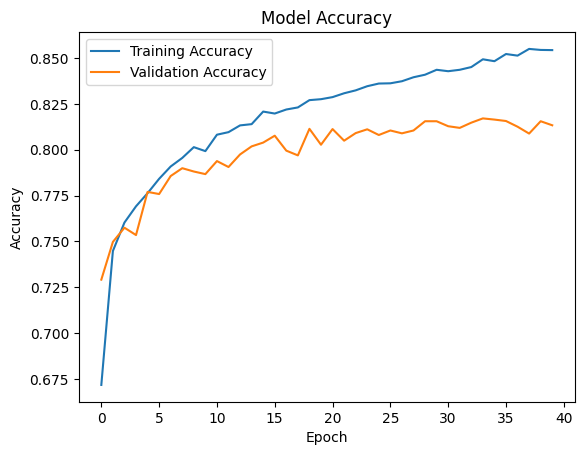

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

404/404 [==============================] - 1s 2ms/step - loss: 0.5290 - accuracy: 0.8257
Test Accuracy: 82.57%


404/404 [==============================] - 1s 1ms/step


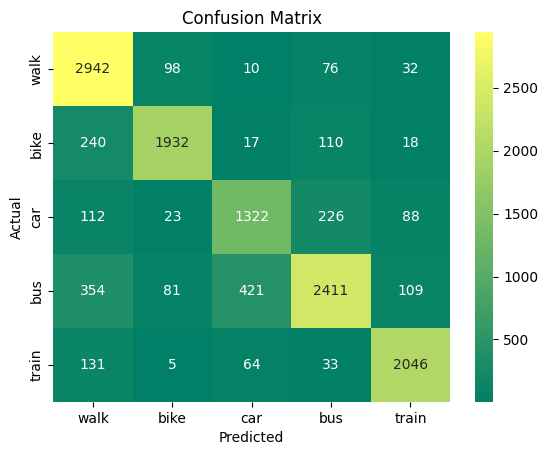

              precision    recall  f1-score   support

        walk       0.78      0.93      0.85      3158
        bike       0.90      0.83      0.87      2317
         car       0.72      0.75      0.73      1771
         bus       0.84      0.71      0.77      3376
       train       0.89      0.90      0.90      2279

    accuracy                           0.83     12901
   macro avg       0.83      0.82      0.82     12901
weighted avg       0.83      0.83      0.82     12901



In [ ]:
# Predict classes on the test set
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Define the class labels
class_labels = ['walk', 'bike', 'car', 'bus', 'train']  # Adjust this to your actual class labels

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, cmap='summer', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

report = classification_report(test_labels, predicted_classes, target_names=['walk', 'bike', 'car', 'bus', 'train'])
print(report)